# QF605 Fixed Income Securities
## Project Part I 
## Bootstrapping Swap Curves
YU Lingfeng

In [1]:
# importing labraries
import numpy as np
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.optimize import brentq, curve_fit, least_squares
from scipy.stats import norm
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

## <a id = "top">Table of Content</a>
### [Q1. OIS discount factor](#p1)   
OIS Discount $(D_o(0, 1y)+ D_o(0, 2y) + ... + D_o(0, T)) \cdot OIS_T=1 - D_o(0,T)$
### [Q2. LIBOR discount factor (Semi-annual payment)](#p2)
$PV_{fix} = 0.5 \cdot (D_o(0, 0.5y)+ D_o(0, 1y)+D_o(0, 1.5y) + ... + D_o(0, T)) \cdot IRS_T=$

$PV_{flt} = D_o(0, 0.5y)\cdot \frac{\tilde{D}(0, 0)-\tilde{D}(0, 0.5y)}{\tilde{D}(0, 0.5y)} + D_o(0, 1y)\cdot \frac{\tilde{D}(0, 0.5y)-\tilde{D}(0, 1y)}{\tilde{D}(0, 1y)}+...+D_o(0, T-0.5y)\cdot \frac{\tilde{D}(0, T-0.5y)-\tilde{D}(0, T)}{\tilde{D}(0, T)} =$

$(D_o(0, 0.5y )\cdot\frac{\tilde{D}(0,0)}{\tilde{D}(0,0.5y)}+D_o(0, 1y)\cdot\frac{\tilde{D}(0,0.5y)}{\tilde{D}(0,1y)}+...+D_o(0, T)\cdot\frac{\tilde{D}(0,T-0.5y)}{\tilde{D}(0,T)})-((D_o(0, 0.5y)+ D_o(0, 1y)+D_o(0, 1.5y) + ... + D_o(0, T)))$

### [Q3.  Forward Swap Rates (Semi-annual payment)](#p3)

$PV_{fix} = S_{t, t+\Delta} \cdot 0.5 \cdot (D_o(0, t+0.5)+ D_o(0, t+1)+D_o(0, t+1.5y) + ... + D_o(0, t+\Delta))=$

$PV_{flt} = D_o(0, t+0.5)\cdot \frac{\tilde{D}(0, 0t)-\tilde{D}(0, t+0.5)}{\tilde{D}(0, t+0.5)} + D_o(0, t+1)\cdot \frac{\tilde{D}(0, t+0.5)-\tilde{D}(0, t+1)}{\tilde{D}(0, t+1)}+...+D_o(0, t+\Delta )\cdot \frac{\tilde{D}(0, t+\Delta-0.5)-\tilde{D}(0, t+\Delta)}{\tilde{D}(0, t+\Delta)} =$

$(D_o(0, t+0.5 )\cdot\frac{\tilde{D}(0,0)}{\tilde{D}(0,t+0.5)}+D_o(0, t+1)\cdot\frac{\tilde{D}(0,t+0.5)}{\tilde{D}(0,t+1)}+...+D_o(0, t+\Delta)\cdot\frac{\tilde{D}(0,t+\Delta-0.5)}{\tilde{D}(0,t+\Delta)})-((D_o(0, t+0.5)+ D_o(0, t+1)+D_o(0, t+1.5) + ... + D_o(0, t+\Delta)))$

## <a id = "p1"> Q1. </a> OIS discount factor $D_o(0, T)$ [back to table of contents](#top)

OIS Discount $(D_o(0, 1y)+ D_o(0, 2y) + ... + D_o(0, T)) \cdot OIS_T=1 - D_o(0,T)$

(Fixed Leg Annual payment)

In [2]:
OIS =\
    pd.read_excel('IR Data.xlsx',
                  sheet_name='OIS', 
                  index_col = 0)
print(OIS.index)
OIS.head(3)

Index(['6m', '1y', '2y', '3y', '4y', '5y', '7y', '10y', '15y', '20y', '30y'], dtype='object', name='Tenor')


,Product,Rate,Unnamed: 3,Unnamed: 4,Unnamed: 5
Tenor,,,,,
6m,OIS,0.00250,NaN,Day Count Convention,30/360
1y,OIS,0.00300,NaN,O/N Leg Frequency,Daily
2y,OIS,0.00325,NaN,Fixed Leg Frequency,Annual


In [3]:
ois =\
   OIS.iloc[:,1:2] 
ois.index =\
    [0.5] +\
    list(range(1,6)) +\
    [7] +\
    list(range(10,21,5)) +\
    [30]

ois['DF'] = np.nan
ois.iloc[:2, 1] =\
    1 / (1 + ois.index[:2] * ois.iloc[:2,0])

ois.head(3)

,Rate,DF
0.5,0.00250,0.998752
1.0,0.00300,0.997009
2.0,0.00325,NaN


In [4]:
ois_all =\
    pd.concat([ois, 
               pd.DataFrame(index = range(1,30))],
              axis = 0)\
    .reset_index()\
    .drop_duplicates(subset='index',
                     keep='first')\
    .set_index('index')\
    .sort_index()
ois_all.index.name = 'OIS Tenor'

ois_all.head(3)

,Rate,DF
OIS Tenor,,
0.5,0.00250,0.998752
1.0,0.00300,0.997009
2.0,0.00325,NaN


In [5]:
na_rate = 0
D_pre = 1
for i in range(2,len(ois_all)):
    if pd.isna(ois_all.iloc[i, 0]):
        na_rate += 1
    
    else:
#         print(na_rate, i)
        r_ois = ois_all.iloc[i, 0]
        if na_rate == 0:
            DF =\
                (1 - sum(ois_all.iloc[1:i, 1]) * r_ois)/\
                (1 + r_ois)
            
            ois_all.iloc[i,1] = DF
#             print(DF)
        elif na_rate > 0:
            D_part =\
                (na_rate+2) / 2 * r_ois
            DF =\
                (1 - D_part * ois_all.iloc[D_pre, 1] -\
                sum(ois_all.iloc[1:D_pre, 1]) * r_ois) /\
                (1 + D_part)
            ois_all.iloc[i,1] = DF
            ois_all.iloc[:i+1,1] =\
                ois_all.iloc[:i+1,1].interpolate(method = 'linear')
        D_pre = i
        na_rate = 0

ois_all

,Rate,DF
OIS Tenor,,
0.5,0.00250,0.998752
1.0,0.00300,0.997009
2.0,0.00325,0.993531
3.0,0.00335,0.990015
4.0,0.00350,0.986117
5.0,0.00360,0.982184
6.0,NaN,0.977295
7.0,0.00400,0.972406
8.0,NaN,0.966929


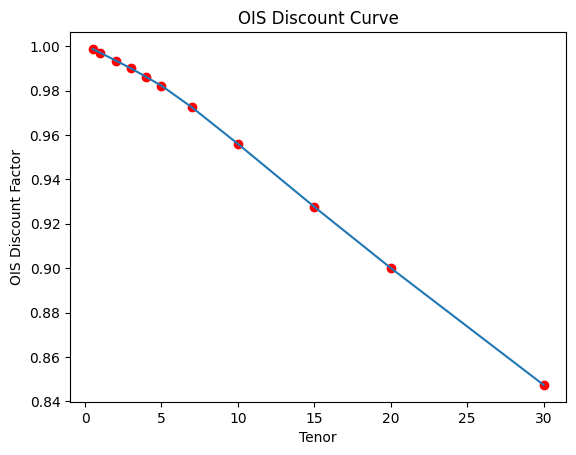

In [6]:
plt.scatter(ois.index,
            ois_all.loc[~ois_all['Rate'].isna()]['DF'],
            c = 'r')
plt.plot(ois_all.index,
         ois_all['DF'])
plt.ylabel('OIS Discount Factor')
plt.xlabel('Tenor')
plt.title('OIS Discount Curve')
plt.savefig('P1_OIS_discount_curve.png')
plt.show()

## <a id = "p2"> Q2. </a> LIBOR discout factor $D(0, T)$ [back to table of contents](#top)

Collateralized LIBOR Discount Factor (Semi-Annual payment)

$PV_{fix} = 0.5 \cdot (D_o(0, 0.5y)+ D_o(0, 1y)+D_o(0, 1.5y) + ... + D_o(0, T)) \cdot IRS_T=$

$PV_{flt} = D_o(0, 0.5y)\cdot \frac{\tilde{D}(0, 0)-\tilde{D}(0, 0.5y)}{\tilde{D}(0, 0.5y)} + D_o(0, 1y)\cdot \frac{\tilde{D}(0, 0.5y)-\tilde{D}(0, 1y)}{\tilde{D}(0, 1y)}+...+D_o(0, T-0.5y)\cdot \frac{\tilde{D}(0, T-0.5y)-\tilde{D}(0, T)}{\tilde{D}(0, T)} =$

$(D_o(0, 0.5y )\cdot\frac{\tilde{D}(0,0)}{\tilde{D}(0,0.5y)}+D_o(0, 1y)\cdot\frac{\tilde{D}(0,0.5y)}{\tilde{D}(0,1y)}+...+D_o(0, T)\cdot\frac{\tilde{D}(0,T-0.5y)}{\tilde{D}(0,T)})-((D_o(0, 0.5y)+ D_o(0, 1y)+D_o(0, 1.5y) + ... + D_o(0, T)))$

In [7]:
IRS =\
    pd.read_excel('IR Data.xlsx',
                  sheet_name='IRS', 
                  index_col = 0)
IRS

,Product,Rate,Unnamed: 3,Unnamed: 4,Unnamed: 5
Tenor,,,,,
6m,LIBOR,0.0250,NaN,Day Count Convention,30/360
1y,IRS,0.0280,NaN,Fixed Leg Freq,Semi-annual
2y,IRS,0.0300,NaN,Floating Leg Freq,Semi-annual
3y,IRS,0.0315,NaN,NaN,NaN
4y,IRS,0.0325,NaN,NaN,NaN
5y,IRS,0.0330,NaN,NaN,NaN
7y,IRS,0.0350,NaN,NaN,NaN
10y,IRS,0.0370,NaN,NaN,NaN
15y,IRS,0.0400,NaN,NaN,NaN


In [8]:
irs =\
   IRS.iloc[:,0:2] 
irs.index =\
    [0.5] +\
    list(range(1,6)) +\
    [7] +\
    list(range(10,21,5)) +\
    [30]
irs.index.name =\
    'Tenor'
irs.columns =\
    ['Product', 'Rate']
irs['OIS DF'] =\
    ois_all\
    .loc[~ois_all['Rate'].isna()]\
    ['DF']
irs['LIBOR DF'] = np.nan

df_all =\
    pd.concat([irs, 
               pd.DataFrame(index = np.arange(0.5,30.5,0.5))],
              axis = 0)\
    .reset_index()\
    .drop_duplicates(subset='index',
                     keep='first')\
    .set_index('index')\
    .sort_index()
df_all.index.name = 'Tenor'
df_all['OIS DF'] =\
    df_all['OIS DF'].interpolate()
df_all.iloc[0,3] =\
    1/(1+0.5*df_all.iloc[0,1])
df_backup = df_all.copy()

In [9]:
def flt_part(df, i, x):
    temp_df = df.copy()
    temp_df.iloc[i,3] = x
    temp_df.iloc[:i+1,3] =\
        temp_df.iloc[:i+1,3]\
        .interpolate()
    
    flt_part_sum =\
        temp_df.iloc[0,2] *\
        1 /\
        temp_df.iloc[0,3]
    for j in range(1, i+1):
        flt_part_sum +=\
            temp_df.iloc[j,2] * \
            temp_df.iloc[j-1,3] /\
            temp_df.iloc[j,3]            
        
    fix_part_sum =\
        sum(temp_df.iloc[:i+1,2])
    net_zero =\
        flt_part_sum - fix_part_sum *\
        (1 + 0.5 * temp_df.iloc[i,1])
    return net_zero

In [10]:
df_all = df_backup.copy()
for i in range(1, len(df_all)):

    if not pd.isna(df_all.iloc[i, 1]):
#         print(na_rate, i)
        DF =\
            brentq(lambda x: flt_part(df_all, i, x), 0.0001, 1)

        df_all.iloc[i,3] = DF
        df_all.iloc[:i+1,3] =\
            df_all.iloc[:i+1,3]\
            .interpolate(method = 'linear')

#     if i == 3:
#         break
df_all.loc[~df_all['Rate'].isna()]

,Product,Rate,OIS DF,LIBOR DF
Tenor,,,,
0.5,LIBOR,0.0250,0.998752,0.987654
1.0,IRS,0.0280,0.997009,0.972577
2.0,IRS,0.0300,0.993531,0.942179
3.0,IRS,0.0315,0.990015,0.910482
4.0,IRS,0.0325,0.986117,0.878981
5.0,IRS,0.0330,0.982184,0.848989
7.0,IRS,0.0350,0.972406,0.784216
10.0,IRS,0.0370,0.955977,0.692710
15.0,IRS,0.0400,0.927611,0.551081


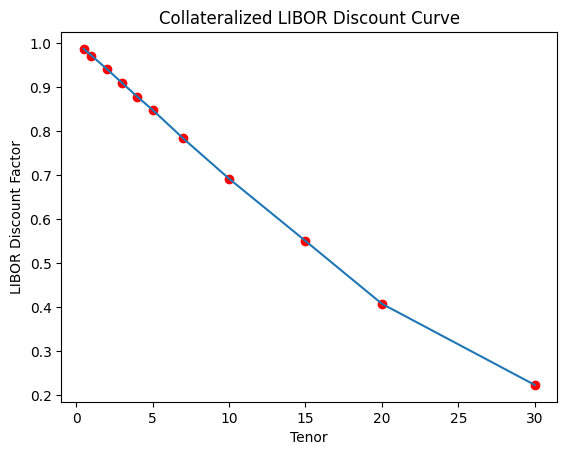

In [11]:
plt.scatter(irs.index,
            df_all.loc[~df_all['Rate'].isna()]['LIBOR DF'],
            c = 'r')
plt.plot(df_all.index,
         df_all['LIBOR DF'])
plt.ylabel('LIBOR Discount Factor')
plt.xlabel('Tenor')
plt.title('Collateralized LIBOR Discount Curve')
plt.savefig('P1_LIBOR_discount_curve.png')
plt.show()

## <a id = "p3"> Q3. </a> forward swap rates $D(t, T)$ [back to table of contents](#top)

$PV_{fix} = S_{t, t+\Delta} \cdot 0.5 \cdot (D_o(0, t+0.5)+ D_o(0, t+1)+D_o(0, t+1.5y) + ... + D_o(0, t+\Delta))=$

$PV_{flt} = D_o(0, t+0.5)\cdot \frac{\tilde{D}(0, 0t)-\tilde{D}(0, t+0.5)}{\tilde{D}(0, t+0.5)} + D_o(0, t+1)\cdot \frac{\tilde{D}(0, t+0.5)-\tilde{D}(0, t+1)}{\tilde{D}(0, t+1)}+...+D_o(0, t+\Delta )\cdot \frac{\tilde{D}(0, t+\Delta-0.5)-\tilde{D}(0, t+\Delta)}{\tilde{D}(0, t+\Delta)} =$

$(D_o(0, t+0.5 )\cdot\frac{\tilde{D}(0,0)}{\tilde{D}(0,t+0.1)}+D_o(0, t+1)\cdot\frac{\tilde{D}(0,t+0.5)}{\tilde{D}(0,t+1)}+...+D_o(0, t+\Delta)\cdot\frac{\tilde{D}(0,t+\Delta-0.5)}{\tilde{D}(0,t+\Delta)})-((D_o(0, t+0.5)+ D_o(0, t+1)+D_o(0, t+1.5) + ... + D_o(0, t+\Delta)))$

In [12]:
df_all[['OIS DF','LIBOR DF']].to_csv('###P1 All DFs.csv')
df_all.head()

,Product,Rate,OIS DF,LIBOR DF
Tenor,,,,
0.5,LIBOR,0.025,0.998752,0.987654
1.0,IRS,0.028,0.997009,0.972577
1.5,NaN,NaN,0.995270,0.957378
2.0,IRS,0.030,0.993531,0.942179
2.5,NaN,NaN,0.991773,0.926330


In [13]:
expiry = [1, 5, 10]
Tenor = [1, 2, 3, 5, 10]
S=[]
for ex in expiry:
    S_Ts = []
    for T in Tenor:
        df_eff =\
            df_all.loc[ex:ex+T]
        fix_part_sum =\
            sum(df_eff.iloc[1:, 2])
        flt_part_sum = 0
        for i in range(1,len(df_eff)):
            flt_part_sum +=\
                df_eff.iloc[i,2] * \
                df_eff.iloc[i-1,3] /\
                df_eff.iloc[i,3]          
        
        S_T =\
            (flt_part_sum - fix_part_sum) /\
            (0.5 * fix_part_sum)
        S_Ts += [S_T]
        
        
    S += [S_Ts]
    
S = pd.DataFrame(S, 
                 columns = ['X '+str(Tn)+'y' for Tn in Tenor], 
                 index = [str(Ex)+'y' for Ex in expiry])
S.index.name = 'Expiry/Tenor'
S.to_csv('###P1 Forward Swap Rate.csv')
S

,X 1y,X 2y,X 3y,X 5y,X 10y
Expiry/Tenor,,,,,
1y,0.032007,0.033259,0.034011,0.035255,0.038428
5y,0.039274,0.040075,0.040072,0.041093,0.043634
10y,0.042189,0.043116,0.044097,0.046249,0.053458
